In [143]:
from io import open
import unicodedata
import string
import re
import time
import math
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from nltk.translate.bleu_score import sentence_bleu
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Создадим класс словаря, где есть будут словари для кодирования и декодирования слов, словарь учета количества слов и счетчик слов.

In [122]:
SOS_token = 0
EOS_token = 1

class LanguageVocabulary(object):
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

##### Создадим функции для "очистки" от символов вне кодировки ASCII и сопостовления символам данной кодировки (если это возможно)

In [123]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

##### Создаем пары объектов словаря для данного файла

In [124]:
def read_languages(lang1 = 'eng', lang2 = 'isl', reverse=False):
    print("Reading lines...")
    lines = open('isl-eng/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    pairs = [[normalize_string(s) for s in l.split('\t')[:2]] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = LanguageVocabulary(lang2)
        output_lang = LanguageVocabulary(lang1)
    else:
        input_lang = LanguageVocabulary(lang1)
        output_lang = LanguageVocabulary(lang2)
    return input_lang, output_lang, pairs

##### Ограничим максимальную длниу фразы для лучшего результата

In [125]:
MAX_LENGTH = 10

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [126]:
def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_languages(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [127]:
input_lang, output_lang, pairs = prepare_data('eng', 'isl', True)
print(random.choice(pairs))

Reading lines...
Read 6674 sentence pairs
Trimmed to 4709 sentence pairs
Counting words...
Counted words:
isl 3901
eng 2652
['eg er ekki lengur kennari inn .', 'i m not your teacher anymore .']


In [128]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [129]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

##### Технические функции

In [130]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepare_data('eng', 'isl', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [131]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [132]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [133]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [134]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [146]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                # decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [136]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Reading lines...
Read 6674 sentence pairs
Trimmed to 4709 sentence pairs
Counting words...
Counted words:
isl 3901
eng 2652
0m 32s (- 8m 3s) (5 6%) 2.6865
1m 6s (- 7m 47s) (10 12%) 1.6062
1m 43s (- 7m 27s) (15 18%) 1.0386
2m 26s (- 7m 18s) (20 25%) 0.6638
3m 5s (- 6m 48s) (25 31%) 0.4217
3m 44s (- 6m 14s) (30 37%) 0.2636
4m 30s (- 5m 48s) (35 43%) 0.1689
5m 11s (- 5m 11s) (40 50%) 0.1130
5m 51s (- 4m 33s) (45 56%) 0.0787
6m 28s (- 3m 53s) (50 62%) 0.0618
7m 5s (- 3m 13s) (55 68%) 0.0457
7m 44s (- 2m 34s) (60 75%) 0.0371
8m 20s (- 1m 55s) (65 81%) 0.0334
8m 57s (- 1m 16s) (70 87%) 0.0293
9m 34s (- 0m 38s) (75 93%) 0.0266
10m 10s (- 0m 0s) (80 100%) 0.0231


<Figure size 640x480 with 0 Axes>

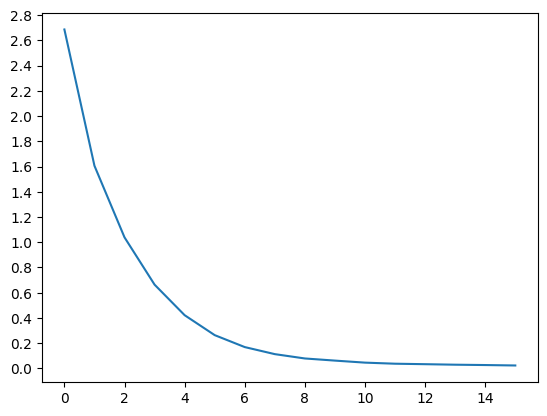

In [137]:
# hidden_size = 128
# batch_size = 32

# input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

# encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
# decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [156]:
# torch.save(encoder.state_dict(), '/Users/maksimyesmantovich/Documents/DS/HW/hw_module5/Translator_rus_to_eng/Encoder')
# torch.save(decoder.state_dict(), '/Users/maksimyesmantovich/Documents/DS/HW/hw_module5/Translator_rus_to_eng/Decoder')

In [158]:
hidden_size = 128

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

encoder.load_state_dict(torch.load('Encoder'))
decoder.load_state_dict(torch.load('Decoder'))

<All keys matched successfully>

In [159]:
def calculate_score(encoder,decoder,pairs):
    bleu_scores = []
    reference = [pair[1].split(' ') for pair in pairs] 
    
    for pair in pairs:
        candidate, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang) 
        
        score = sentence_bleu(reference,candidate)
        bleu_scores.append(score)
    
    return (sum(bleu_scores)/len(pairs))*100

In [160]:
print('BLEU score: {} %'.format(round(calculate_score(encoder, decoder, pairs[0:2000])), 2))

BLEU score: 63 %
